# 👋 Welcome to the **semantic segementation** for Attribution methods tutorial

The objective of this notebook is to apply the xplique library to a image semantic segmentation problem. We use a [lraspp mobilenet from torchvision](https://pytorch.org/vision/stable/models/generated/torchvision.models.segmentation.lraspp_mobilenet_v3_large.html) and follow the [torchvision pipeline](https://pytorch.org/vision/stable/models.html#semantic-segmentation) to load it and make inferences.

This notebook suppose that the reader is familiar with Xplique attribution methods, otherwise, we recommend to begin with the [Attributions: Getting started tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2).

---

### 🔵 <font color='lightblue'>Information</font>
Xplique is initially a tensorflow library and the model used in this tutorial is in pytorch hence there are some parts specific to pytorch. The code cells specific to pytorch will be marked with a `# WARNING: specific to pytorch`. To know more on how to apply Xplique on pytorch models please follow the [xplique pytorch documentation](https://deel-ai.github.io/xplique/latest/api/attributions/pytorch/) and [xplique pytorch tutorial](https://colab.research.google.com/drive/1bMlO29_0K3YnTQBbbyKQyRfo8YjvDbhe).

---

_Author: Antonin Poché_

---

## ⚙️ How does attribution methods work for semantic segmentation?

### 💡 The intuition

The attribution methods were mostly defined for classification and in some cases for regression. Therefore, to apply such methods to semantic segmentation, some modifications should be applied.

In semantic segmentation, there is not a classification by image but a classification for each pixel of a given image. However, it is not pertinent to explain each pixel individually, hence there is a necessity to group pixels together and reduce the prediction of the model on those pixels to one value so that attributions can be computed.

The choice of Xplique is:
- For perturbation methods, xplique study the difference between the mean initial logits and logits on perturbed images. Limited to the pixels belonging to a zone and class of interest.
- For gradient-based methods, xplique study the gradient of the mean logits values of pixels of the zone and class of interest.

Those two cases are the behavior of the semantic segmentation operator. More detail in the [semantic segmentation documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/).


### 🎯 What can be explained with it?

Many possibilities can be listed by the user as things to explain, but in most cases, it boils dow to four possibilities:
- Explaining the predicted class in a zone of interest. For example, explain why two pedestrians are classified as persons or why the arm of a person was classified as a tree.
- Explaining the border of a zone of interest, i.e. why are pixels predicted from one class just inside the zone and not just outside.
- Explaining the border between two zones of interest (why is the limit between those two predictions there).
- Explaining all pixels predicted as being from the same class, this part makes sense for crowd of objects such as a crowd on a street, clouds, or a flock of birds.

Those four possibilites specified through the `targets` parameter of the `explain` method, to design the value for this parameter, xplique proposes a set of functions in `xplique.utils.segmentation`. More detail in the [documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/).


## 🏗️ Build the usecase

### 📦 imports

In [1]:
import requests

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

# in this tutorial, images have a size of 520x520 which is memory consuming during computations
# hence a smaller batch_size than default 32 value of Xplique is specified
BATCH_SIZE = 8

/home/hinton/anaconda3/envs/brito/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 🖼️ Get an image

In [22]:
dataset, info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    with_info=True,
    shuffle_files=True,
    data_dir='/home/hinton/brito/datasets/',
)

print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/home/hinton/brito/datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    s

In [23]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(
        input_image,
        (256, 256),
        method="nearest"
    )
    input_mask = tf.image.resize(input_mask, (256, 256), method="nearest")

    return input_image, input_mask


In [24]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


In [25]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [28]:
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

### ⤵️ Load model

In [5]:
class BPCAPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, stride=2, n_components=1, expected_shape=None, **kwargs):
        super(BPCAPooling, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.n_components = n_components
        self.expected_shape = expected_shape

        self.patch_size = [1, self.pool_size, self.pool_size, 1]
        self.strides = [1, self.stride, self.stride, 1]

    def build(self, input_shape):
        super(BPCAPooling, self).build(input_shape)

    @tf.function
    def bpca_pooling(self, feature_map):
        # Compute the region of interest
        h, w, c = self.expected_shape  # block_height, block_width, block_channels
        d = c // (self.pool_size * self.pool_size)  # block_depth

        # Create blocks (patches)
        data = tf.reshape(feature_map, [1, h, w, c])
        patches = tf.image.extract_patches(
            images=data,
            sizes=self.patch_size,
            strides=self.strides,
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(
            patches,
            [h*w*d, self.pool_size * self.pool_size]
        )

        # Normalize the data by subtracting the mean and dividing by the standard deviation
        mean = tf.reduce_mean(patches, axis=0)
        std = tf.math.reduce_std(patches, axis=0)
        patches = (patches - mean) / std
        patches = tf.where(tf.math.is_nan(patches), 0.0, patches)

        # Perform the Singular Value Decomposition (SVD) on the data
        _, _, v = tf.linalg.svd(patches)

        # Extract the first n principal components from the matrix v
        pca_components = v[:, :self.n_components]

        # Perform the PCA transformation on the data
        transformed_patches = tf.matmul(patches, pca_components)
        return tf.reshape(transformed_patches, [h // self.pool_size, w // self.pool_size, c])

    def call(self, inputs):
        pooled = tf.vectorized_map(self.bpca_pooling, inputs)
        return pooled


In [6]:
def get_layers_nmb_unetlike_pooling(number):
    if number == 32:
        return (256, 256, 32)
    if number == 64:
        return (128, 128, 64)
    if number == 128:
        return (64, 64, 128)
    if number == 256:
        return (32, 32, 256)
    if number == 512:
        return (16, 16, 512)
    else:
        return (0, 0, 0)


def get_layers_nmb_unetlike_unpooling(number):
    if number == 256:
        return (32, 32, 256)
    if number == 128:
        return (64, 64, 128)
    if number == 64:
        return (128, 128, 64)
    if number == 32:
        return (256, 256, 32)


In [7]:
def mean_iou(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.int32) 
    y_pred = tf.cast(y_pred > 0.5, tf.int32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / union
    return iou

In [8]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0  # to avoid division by zero
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coefficient

In [10]:
from keras.models import load_model

model = load_model(
    "/home/hinton/brito/models/bpca_unetlike.h5",
    custom_objects={'mean_iou': mean_iou, 'dice_coefficient': dice_coefficient, 'BPCAPooling': BPCAPooling}
)

## 🎁 Prepare model for Xplique (uses wrappers)


### 🔵 <font color='lightblue'>Information</font>

The wrapper steps are needed only if:
- The model does not matches the format described in the [xplique semantic segmentation documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/).
- Or, the model is not a `tf.keras.Model`.

### 🌯 Wrap model to match the expected format

In case the model do not match the expected format for the `segmentation_operator`, it needs to be wrapped. More detail on this operator are available in the [xplique semantic segmentation documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/).

Furthermore, pytorch models will need to be wrapped two times. First as described in this section and then with the `TorchWrapper` (which is done in one line).

---

#### Model constraints

- The `__call__` function of the model should be able to make an inference from the inputs to the semantic segmentation without additionnal functions. For gradient-based methods, this function should also be differentiable.

- The expected input and output shapes are $(n, h, w, c_{in})$ and $(n, h, w, c_{out})$, with $c_{in}$ the number of channels of the image, usually 3 and $c_{out}$ the number of classes.

In this example, it was necessary to make a wrapper because the model did not match the expected format on several points:
- The output is a dictionnary and a `output["out"]` was necessary.
- It is a pytorch model, so the output had channel first. (The input too, but it is treated in the `TorchWrapper` afterward). Furthermore for models that will afterward wrapped with the `TorchWrapper`, the `to()` and the `zero_grad()` methods need to be overwritten. (For more information on the `TorchWrapper`, please refer to the the pytorch [documentation](https://deel-ai.github.io/xplique/latest/api/attributions/pytorch/) and [tutorial](https://colab.research.google.com/drive/1bMlO29_0K3YnTQBbbyKQyRfo8YjvDbhe)).
- The values were not between 0 and 1, so we needed to apply a `softmax` function. (The 0-1 constraint comes from the segmentation operator, see the corresponding [documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/) for more details).

---

If a wrapper is necessary, like in most case, it will not work on methods modifying the model:

<a name="available_methods"></a>

| **Attribution Method** | Wrapper compatible |
| :--------------------- | :----------------: |
| Deconvolution          | ❌                |
| Grad-CAM               | ❌                |
| Grad-CAM++             | ❌                |
| Gradient Input         | ✅                |
| Guided Backprop        | ❌                |
| Hsic Attribution       | ✅                |
| Integrated Gradients   | ✅                |
| Kernel SHAP            | ✅                |
| Lime                   | ✅                |
| Occlusion              | ✅                |
| Rise                   | ✅                |
| Saliency               | ✅                |
| SmoothGrad             | ✅                |
| SquareGrad             | ✅                |
| Sobol Attribution      | ✅                |
| VarGrad                | ✅                |

In [ ]:
class ModelWrapper(tf.keras.Model):
    # WARNING: `torch.nn.Module` specific to pytorch
    # `tf.keras.Model` instead for tensorflow models

    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model.eval()

    def __call__(self, torch_inputs):
        # this method should change depending on the model
        return self.model(torch_inputs)


In [ ]:
segmentation_model = ModelWrapper(model)

## 🧪 Test wrapped model and visualize predictions

Through the wrappers, several problems may occur, hence it is recommended to test the inference before applying attribution methods. Furthermore, the inferences are necessary to define the targets parameters of the `explain` method of attribution methods.

In [158]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [159]:
# test initial model
input_images = test_batches.take(1)
tf_outputs = model.predict(input_images)

# test wrapped model
# tf_outputs = wrapped_model(processed_tf_inputs)
print(tf_outputs.shape)

1/1 [==============================] - 1s 897ms/step
(8, 256, 256, 3)


In [160]:
categories = ['pet','background', 'countour']

1/1 [==============================] - 0s 13ms/step


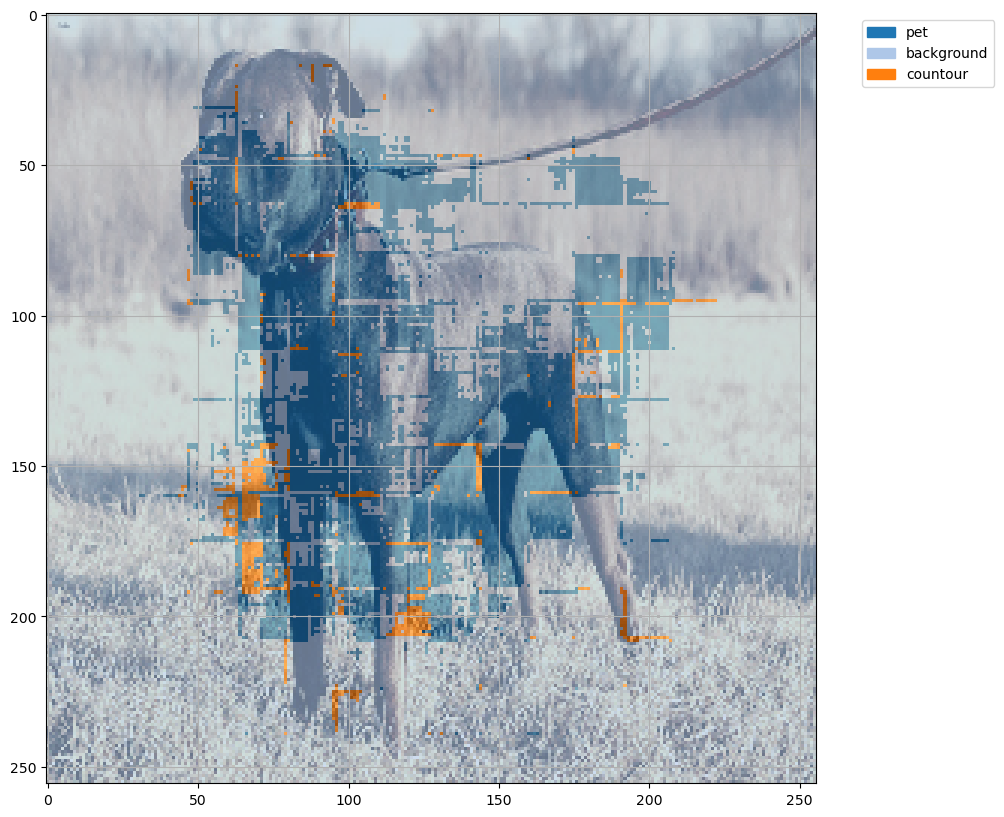

In [161]:
import matplotlib.patches as mpatches

alpha = 0.6
colormap = np.asarray(plt.get_cmap('tab20').colors)
class_to_idx = {c: i for (i, c) in enumerate(categories)}
idx_to_class = {i: c for (i, c) in enumerate(categories)}

# Convert the `test_batches` dataset into a list and subscript it to access the image
test_images = list(input_images)
test_image, test_mask = test_images[0]
test_image = test_image[0]

# Use the model to predict the segmentation mask
pred_mask = model.predict(test_image[tf.newaxis, ...])
pred_seg = create_mask(pred_mask)

import matplotlib.patches as mpatches

# Initialize an empty 3D array (`color_seg`) with the same height and width as the predicted segmentation map, and 3 color channels.
color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3))

# Loop over each color in the colormap. For each color, update the corresponding pixels in `color_seg` where the predicted label matches the current label. If there are any pixels with the current label in the predicted segmentation map, create a patch object with the current color and label, and append it to the `handles` list for the legend.
handles = []
for (i, color) in enumerate(colormap[:len(categories)]):  # Limit the colormap to the number of categories
    # Update the pixels in `color_seg` where the predicted label matches the current label
    color_seg[pred_seg[:, :, 0] == i] = color

    # Create a patch object with the current color and label
    patch = mpatches.Patch(color=color, label=idx_to_class[i])
    handles.append(patch)

# Overlay the color-coded segmentation map (`color_seg`) on the original image with a certain transparency level (`alpha`).
# And Display the overlaid image using `plt.imshow()`, add a legend using `plt.legend()` with the handles created earlier, and add a grid using `plt.grid()`.
plt.figure(figsize=(10, 10))
plt.imshow(test_image)
plt.imshow(color_seg, alpha=alpha)
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()


## 🔎 Explainability

To explain semantic semantation with attribution methods, there are few differences compared to the usual classification explanations (describe in the [getting started tutorial](https://colab.research.google.com/drive/1XproaVxXjO9nrBSyyy7BuKJ1vy21iHs2)):
- The specified operator should be `operator=xplique.Tasks.SEMANTIC_SEGMENTATION`. This operator requires a specific model format and may need to be wrapped.
- The format of the model differs as the output shape is $(n, h, w, c_{out})$, with $c_{out}$ the number of classes.
- The `targets` parameter need more attention and work as each image requires a manually defined value.

An example of wrapper can be found in previous part, but it possesses some parts specific to pytorch. Examples of targets computation can be found in the following parts. Finally, more detail on those differences can be found in the [xplique semantic segmentation documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/).

But before a detailed description of the `targets` parameter design and the result of the different values, let's see a quick example to obtain explanations with few lines.

### 🚀 Quick start: explain the couple class

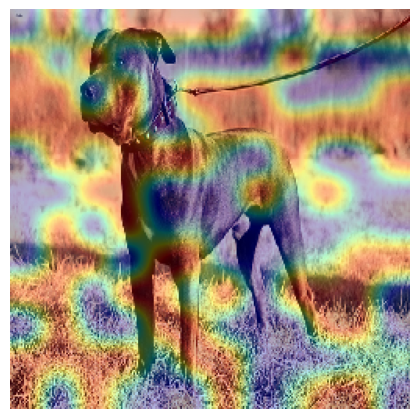

In [187]:
import xplique
from xplique.attributions import HsicAttributionMethod
from xplique.plots import plot_attributions

from xplique.utils_functions.segmentation import get_connected_zone

pet_zone_targets = get_connected_zone(
    pred_seg,
    coordinates=(250, 250)
)[tf.newaxis]

# compute explanation on this zone via HSIC method
explainer = HsicAttributionMethod(
    model,
    operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
    nb_design=750,
    grid_size=12,
    batch_size=BATCH_SIZE
)
explanation = explainer.explain(
    test_image[tf.newaxis],
    pet_zone_targets
)

# add mask to image for visualization (optional)
pet_mask = tf.cast(pet_zone_targets != 0, tf.float32)
image_with_mask = (1 - alpha) * test_image + alpha * pet_mask

# visualize explanation
plot_attributions(
    explanation,
    image_with_mask,
    img_size=4.,
    cmap='jet',
    alpha=0.3,
    absolute_value=False,
    clip_percentile=0.5
)

### 🎯 Prepare `targets` for explanations

The `targets` parameter of the `explain` method specifies what should be explained. In the quick example, the goal was to explain why was the couple zone predicted as beign from the "person" class.

To be able to communicate what to explain to the segmentation operator, the `targets` parameter include two information:
- **The zone of interest**, it represents the zone/pixels on which we want the explanation to be made. It could be a single object like a person, a group of objects like trees, a part of an object that has been wrongly classified, or even the border of an object. Note that the concept of object here only makes sense for us as the model only classifies pixels, which is why xplique include the `xplique.utils.segmentation` set of functions detailed in the [documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/) to ease `targets` building based models predictions.
- **The class of interest**, it represents the channel of the prediction we want to explain. Similarly to classification, we could either want to explain a cat or a dog in the same image. Note that in some case, providing several classes could make sense, for example when explaining the border between two zone of interest, or making contrastive explanations.

Note that the complexity of of semantic segmentation explanations usually requires the design of the `targets` parameter image by image.

For the complete description of the `targets` parameter, please refer to the [xplique semantic segmentation documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/).

---

More concretely, the `targets` parameter can be designed to explain for example:
- The class of a zone of interest.
- The border of a zone of interest.
- The border between two zones of interest.

---

To do so, the `xplique.utils.segmentation` set of functions detailed in [xplique semantic segmentation documentation](https://deel-ai.github.io/xplique/latest/api/attributions/semantic_segmentation/) can be used. Otherwise, the same documentation can be used to understand how to manually design one.

In [191]:
from xplique.utils_functions.segmentation import get_connected_zone, get_in_out_border, get_common_border

predictions = tf_outputs[0]
assert len(predictions.shape) == 3

# specify the coordinate of a point in the zone to explain
pet_coordinates = (200, 50)
background_coordinates = (50, 250)

# compute the `targets` parameter to explain the specified zones
pet_zone_predictions = get_connected_zone(predictions, pet_coordinates)
background_zone_predictions = get_connected_zone(predictions, background_coordinates)

# compute the `targets` parameter to explain the border of the specified zones
pet_borders_predictions = get_in_out_border(pet_zone_predictions)
background_borders_predictions = get_in_out_border(background_zone_predictions)

# compute the `targets` parameter to explain the border between two specified zones
common_border_predictions = get_common_border(pet_zone_predictions, background_borders_predictions)

In [214]:
# tile and stack tensors to call the method once by image
images = tf.tile(test_image[tf.newaxis], (5, 1, 1, 1))
inputs = tf.tile(test_image[tf.newaxis], (5, 1, 1, 1))

targets = tf.stack([
    pet_zone_predictions,
    background_zone_predictions,
    pet_borders_predictions,
    background_zone_predictions,
    common_border_predictions
])

# add the zone mask to the image to visualize
mask_alpha = 0.5
masks = tf.expand_dims(tf.cast(tf.reduce_any(targets != 0, axis=-1), tf.float32), -1)
images_with_masks = (1 - mask_alpha) * images + mask_alpha * masks

### 🔥 Explanations

Saliency


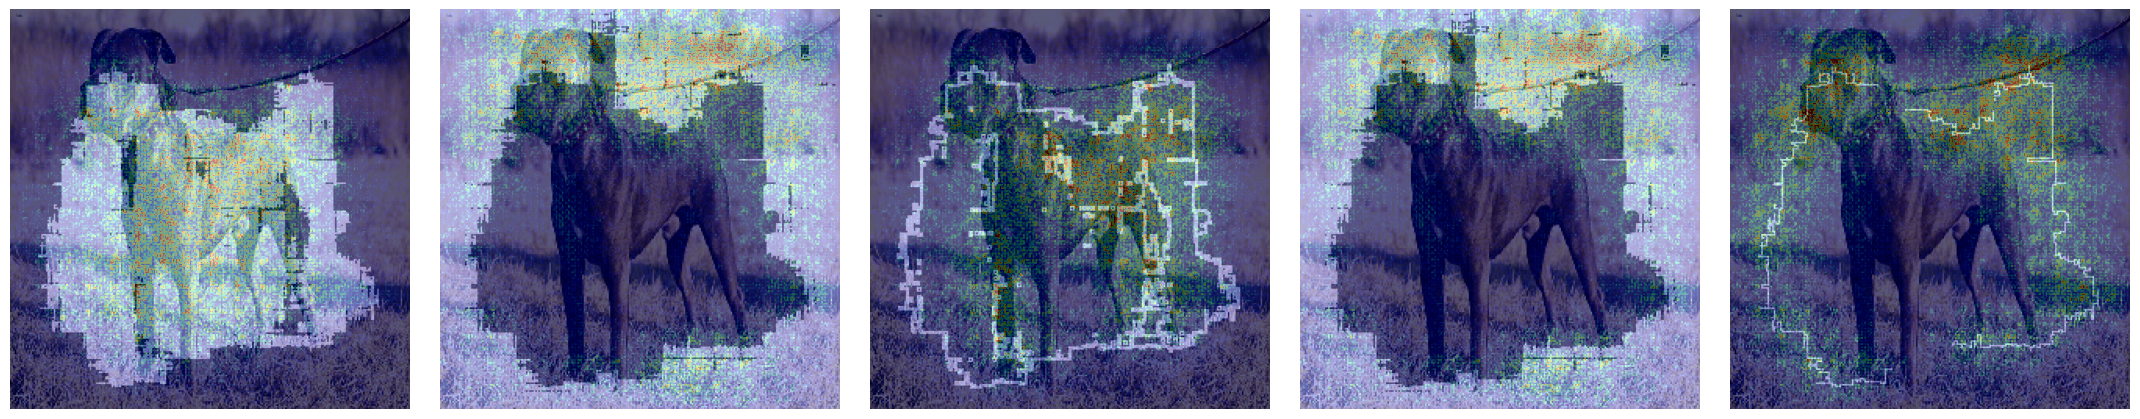

Occlusion


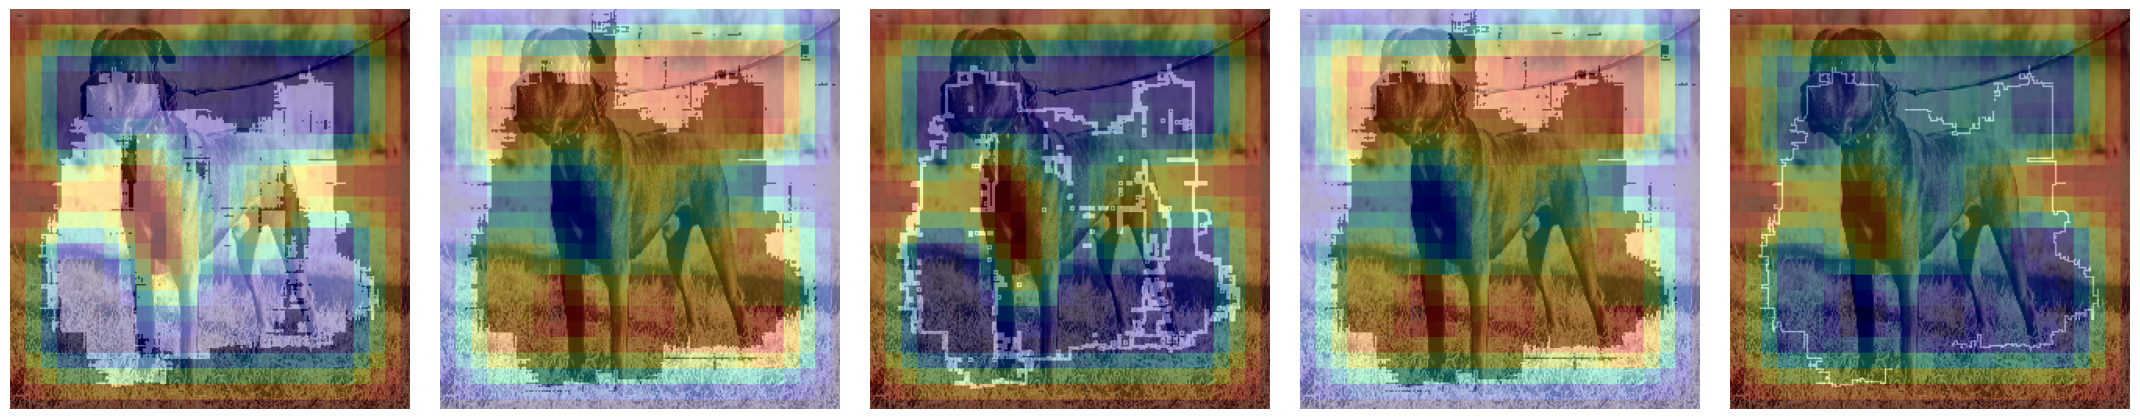

Rise


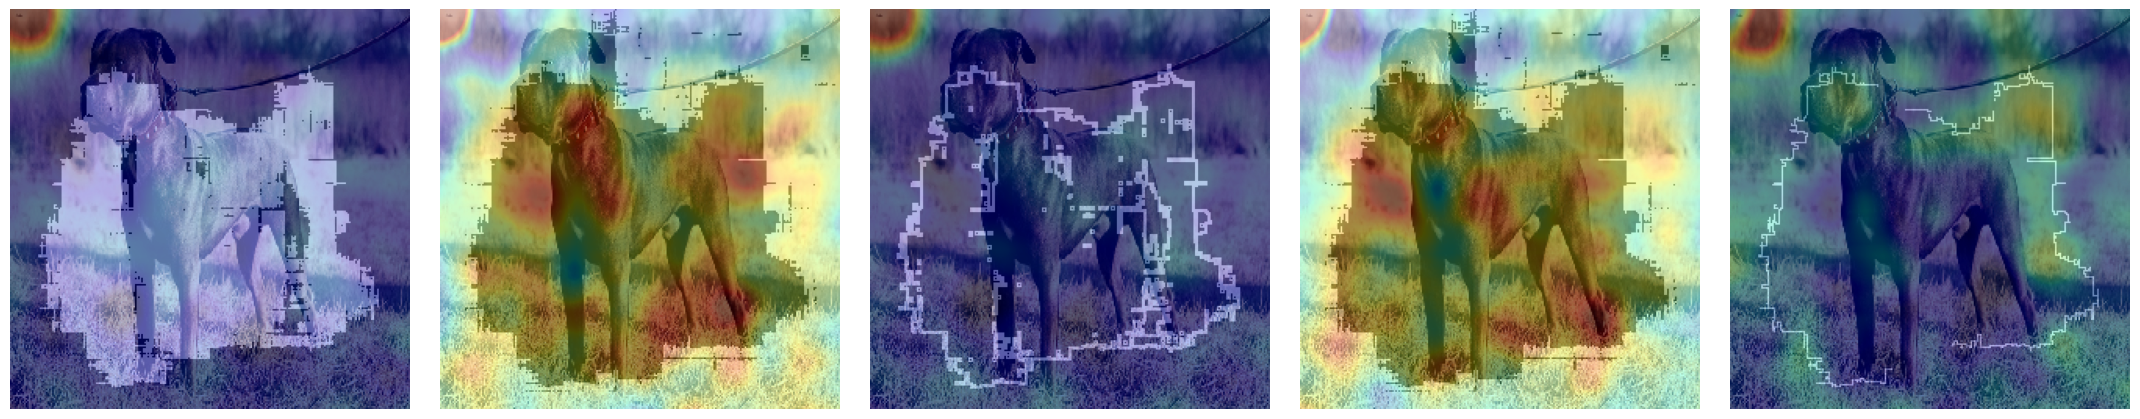

In [215]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad, SquareGrad,
                                  Occlusion, Rise, SobolAttributionMethod, HsicAttributionMethod)

from xplique.plots import plot_attributions

explainers = {
    Saliency: {},
    # GradientInput: {},
    # IntegratedGradients: {"steps": 20},
    # SmoothGrad: {"nb_samples": 50, "noise": 0.75},
    # VarGrad: {"nb_samples": 50, "noise": 0.75},
    # SquareGrad: {"nb_samples": 100, "noise": 0.5},
    Occlusion: {"patch_size": 40, "patch_stride": 10, "occlusion_value": 0},
    Rise: {"nb_samples": 4000, "grid_size": 13},
    # SobolAttributionMethod: {"nb_design": 32, "grid_size": 13},
    # HsicAttributionMethod: {"nb_design": 1500, "grid_size": 13}
}

explanations = {}
for explainer_class, params in explainers.items():
    tf.keras.backend.clear_session()
    plt.clf()
    print(explainer_class.__name__)

    # instanciate explainer
    explainer = explainer_class(
        model,
        operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
        batch_size=BATCH_SIZE,
        **params
    )

    # compute explanations
    explanation = explainer(inputs, targets)

    # show explanations for a method
    plot_attributions(
        explanation,
        images_with_masks,
        img_size=4.,
        cols=images.shape[0],
        cmap='jet',
        alpha=0.3,
        absolute_value=False,
        clip_percentile=0.5
    )
    plt.show()

    # keep explanations in memory for metrics
    explanations[explainer_class.__name__] = explanation


## 📊 Metrics

<Figure size 640x480 with 0 Axes>

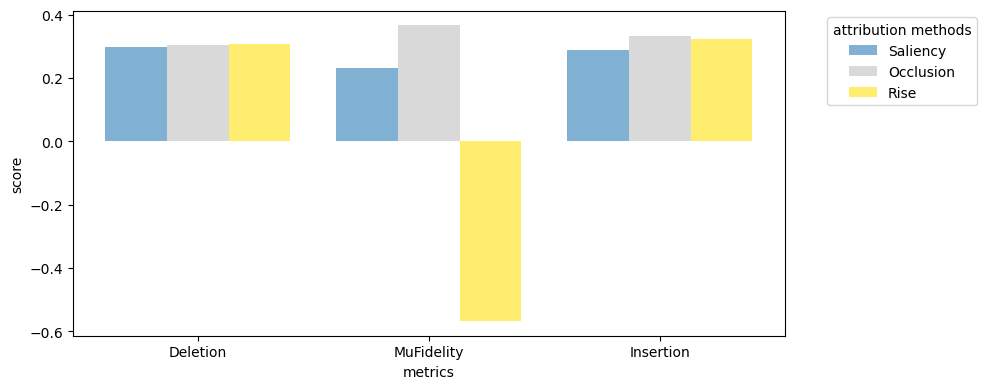

In [219]:
from xplique.metrics import Deletion, MuFidelity, Insertion, AverageStability
from xplique.plots.metrics import barplot

metrics = {}

# -------------------- MuFidelity's nb_samples was reduced for memory needs
# explanations metrics
explanations_metrics = {
    Deletion: {"baseline_mode": 0, "steps": 10, "max_percentage_perturbed": 0.5},
    MuFidelity: {"baseline_mode": 0, "nb_samples": 5, "subset_percent": 0.2, "grid_size": 13},
    Insertion: {"baseline_mode": 0, "steps": 10, "max_percentage_perturbed": 0.5}
}
for metric_class, params in explanations_metrics.items():
    tf.keras.backend.clear_session()
    plt.clf()

    # instanciate the metric
    metric = metric_class(
        model,
        np.array(inputs[:3]),
        np.array(targets[:3]),
        operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
        activation="softmax",
        batch_size=BATCH_SIZE,
        **params
    )

    # iterate on methods explanations
    metrics[metric_class.__name__] = {}
    for method, explanation in explanations.items():
        metrics[metric_class.__name__][method] = metric(explanation[:3])

# # ----------------- Not included for computation cost reason
# # explainer metrics
# metric = AverageStability(model, inputs[:3], targets[:3], batch_size=BATCH_SIZE, nb_samples=20, radius=0.1, distance="l2")
# metrics["AverageStability"] = {}
# for explainer_class, params in explainers.items():
#     tf.keras.backend.clear_session()

#     # instanciate explainer
#     explainer = explainer_class(model, operator=xplique.Tasks.SEMANTIC_SEGMENTATION, batch_size=BATCH_SIZE, **params)

#     metrics["AverageStability"][explainer_class.__name__] = metric.evaluate(explainer)

barplot(metrics, sort_metric="Deletion", ascending="True")
plt.show()

In this case:

- Deletion: lower is better
- Mufidelity: higher is better
- Insertion: higher is better
- AverageStability: lower is better

# 🎉 Congratulations
**you now know how to explain semantic segmentation with Xplique's attribution module !**